<a href="https://colab.research.google.com/github/mariya-goltsova/Parser/blob/main/t5_fine_tuned_with_PLOTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install sentencepiece
!pip install transformers
!pip install rich[jupyter]
!pip install rouge_score
!pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 43.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 61.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 52.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24954 sha256=fe7d18308a4cfd2430b7aa9b1f27bb443dca1b10a797d8afbb6f3e3ac0fc81b1
  Stor

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from datasets import load_dataset, load_metric
dataset = load_dataset('ccdv/arxiv-summarization')

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset arxiv-summarization downloaded and prepared to /root/.cache/huggingface/datasets/ccdv___arxiv-summarization/section/1.0.0/fa2c9abf4312afb8660ef8e041d576b8e3943ea96ae771bd3cd091b5798e7cc3. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
tiny_dataset = dataset['train'].select(list(range(0, 100)))
tiny_dataset_val = dataset['validation'].select(list(range(0, 100)))
text_len = []
summary_len=[]

In [ ]:
import pandas as pd
df = pd.DataFrame(tiny_dataset)
df_val = pd.DataFrame(tiny_dataset_val)

df["article"] = "summarize: "+df["article"]
df_val["article"] = "summarize: "+df_val["article"]

In [ ]:
df.head()

,article,abstract
0,summarize: additive models @xcite provide an i...,additive models play an important role in semi...
1,summarize: the leptonic decays of a charged ps...,"we have studied the leptonic decay @xmath0 , v..."
2,summarize: the transport properties of nonline...,"in 84 , 258 ( 2000 ) , mateos conjectured that..."
3,summarize: studies of laser beams propagating ...,the effect of a random phase diffuser on fluct...
4,summarize: the so - called `` nucleon spin cri...,with a special intention of clarifying the und...


In [ ]:
import time

In [ ]:
# load rouge metric
metric = load_metric("rouge")
import evaluate
rouge_score = evaluate.load("rouge")

<ipython-input-9-0d867c56dc7c>:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("rouge")


In [ ]:
# Importing libraries
import os
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
import os

# Importing the T5 modules from huggingface/transformers
from transformers import T5Tokenizer, T5ForConditionalGeneration

from rich.table import Column, Table
from rich import box
from rich.console import Console

# define a rich console logger
console=Console(record=True)

def display_df(df):
  """display dataframe in ASCII format"""

  console=Console()
  table = Table(Column("source_text", justify="center" ), Column("target_text", justify="center"), title="Sample Data",pad_edge=False, box=box.ASCII)

  for i, row in enumerate(df.values.tolist()):
    table.add_row(row[0], row[1])

  console.print(table)

training_logger = Table(Column("Epoch", justify="center" ), 
                        Column("Steps", justify="center"),
                        Column("Loss", justify="center"), 
                        title="Training Status",pad_edge=False, box=box.ASCII)
losses = []
rouge = []
val_losses = []

In [ ]:
# Setting up the device for GPU usage
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
class YourDataSetClass(Dataset):
  """
  Creating a custom dataset for reading the dataset and 
  loading it into the dataloader to pass it to the neural network for finetuning the model

  """

  def __init__(self, dataframe, tokenizer, source_len, target_len, source_text, target_text):
    self.tokenizer = tokenizer
    self.data = dataframe
    self.source_len = source_len
    self.summ_len = target_len
    self.target_text = self.data[target_text]
    self.source_text = self.data[source_text]

  def __len__(self):
    return len(self.target_text)

  def __getitem__(self, index):
    source_text = str(self.source_text[index])
    target_text = str(self.target_text[index])

    #cleaning data so as to ensure data is in string type
    source_text = ' '.join(source_text.split())
    target_text = ' '.join(target_text.split())

    source = self.tokenizer.batch_encode_plus([source_text], max_length= self.source_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')
    target = self.tokenizer.batch_encode_plus([target_text], max_length= self.summ_len, pad_to_max_length=True, truncation=True, padding="max_length", return_tensors='pt')

    source_ids = source['input_ids'].squeeze()
    source_mask = source['attention_mask'].squeeze()
    target_ids = target['input_ids'].squeeze()
    target_mask = target['attention_mask'].squeeze()

    return {
        'source_ids': source_ids.to(dtype=torch.long), 
        'source_mask': source_mask.to(dtype=torch.long), 
        'target_ids': target_ids.to(dtype=torch.long),
        'target_ids_y': target_ids.to(dtype=torch.long)
    }

In [ ]:
from rouge import Rouge

In [ ]:
rouge_train = []
def train(epoch, tokenizer, model, device, loader, optimizer):

  """
  Function to be called for training with the parameters passed from main function

  """

  model.train()
  for _,data in enumerate(loader, 0):
    #for time getting 
    torch.cuda.synchronize()
    since = int(round(time.time()*1000))
    #time
    y = data['target_ids'].to(device, dtype = torch.long)
    y_ids = y[:, :-1].contiguous()
    lm_labels = y[:, 1:].clone().detach()
    lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
    ids = data['source_ids'].to(device, dtype = torch.long)
    mask = data['source_mask'].to(device, dtype = torch.long)

    outputs = model(input_ids = ids, attention_mask = mask, decoder_input_ids=y_ids, labels=lm_labels)
    loss = outputs[0]

    generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
    preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
    target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]

    rouge_fun1 = Rouge()
    rouge_train.append(rouge_fun1.get_scores(preds, target, avg=True))

    if _%10==0:
      training_logger.add_row(str(epoch), str(_), str(loss))
      console.print(training_logger)
      losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    torch.cuda.synchronize()
    time_elapsed = int(round(time.time()*1000)) - since
    print ('training time elapsed {}ms'.format(time_elapsed))
    

In [ ]:
losses_val = []
def validate(epoch, tokenizer, model, device, loader):

  """
  Function to evaluate model for predictions

  """
  model.eval()
  predictions = []
  actuals = []
  with torch.no_grad():
      for _, data in enumerate(loader, 0):
          y = data['target_ids'].to(device, dtype = torch.long)
          ids = data['source_ids'].to(device, dtype = torch.long)
          mask = data['source_mask'].to(device, dtype = torch.long)

          y_ids = y[:, :-1].contiguous()
          lm_labels = y[:, 1:].clone().detach()
          lm_labels[y[:, 1:] == tokenizer.pad_token_id] = -100
          


          # forward propagation (evaluate model on training batch)
          outputs = model(input_ids=ids,
                            attention_mask=mask,
                            labels=lm_labels,
                            decoder_input_ids=y_ids)

          loss, prediction_scores = outputs[:2]
          if _%10==0:
            losses_val.append(loss.item())

          generated_ids = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=150, 
              num_beams=2,
              repetition_penalty=2.5, 
              length_penalty=1.0, 
              early_stopping=True
              )
          preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_ids]
          target = [tokenizer.decode(t, skip_special_tokens=True, clean_up_tokenization_spaces=True)for t in y]
          if _%10==0:
              console.print(f'Completed {_}')

          predictions.extend(preds)
          actuals.extend(target)
          

          #without description rouge:
          #scores = rouge_score.compute(predictions=preds, references=target)
          #rouge.append(scores)


          rouge_fun = Rouge()
          rouge.append(rouge_fun.get_scores(preds, target, avg=True))



  return predictions, actuals

In [ ]:
# calculate rouge scores
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

In [ ]:
def T5Trainer(dataframe_train, dataframe_val, source_text, target_text, model_params, output_dir="./outputs/", compute_metrics = compute_metrics, predict_with_generate= True):
  
  """
  T5 trainer

  """

  # Set random seeds and deterministic pytorch for reproducibility
  torch.manual_seed(model_params["SEED"]) # pytorch random seed
  np.random.seed(model_params["SEED"]) # numpy random seed
  torch.backends.cudnn.deterministic = True

  # logging
  console.log(f"""[Model]: Loading {model_params["MODEL"]}...\n""")

  # tokenzier for encoding the text
  tokenizer = T5Tokenizer.from_pretrained(model_params["MODEL"])

  # Defining the model. We are using t5-base model and added a Language model layer on top for generation of Summary. 
  # Further this model is sent to device (GPU/TPU) for using the hardware.
  model = T5ForConditionalGeneration.from_pretrained(model_params["MODEL"])
  model = model.to(device)
  
  # logging
  console.log(f"[Data]: Reading data...\n")

  # Importing the raw dataset
  #dataframe = dataframe[[source_text,target_text]]
  #display_df(dataframe.head(2))
  dataframe_val = dataframe_val[[source_text,target_text]]
  #display_df(dataframe_val.head(2))
  dataframe_train = dataframe_train[[source_text,target_text]]
  display_df(dataframe_val.head(2))

  
  # Creation of Dataset and Dataloader
  # Defining the train size. So 80% of the data will be used for training and the rest for validation. 
  #train_size = 0.8
  #train_dataset=dataframe.sample(frac=train_size,random_state = model_params["SEED"])
  train_dataset = dataframe_train
  #val_dataset=dataframe.drop(train_dataset.index).reset_index(drop=True)
  val_dataset = dataframe_val.reset_index(drop=True)
  train_dataset = train_dataset.reset_index(drop=True)

  #console.print(f"FULL Dataset: {dataframe.shape}")
  console.print(f"TRAIN Dataset: {train_dataset.shape}")
  console.print(f"TEST Dataset: {val_dataset.shape}\n")


  # Creating the Training and Validation dataset for further creation of Dataloader
  training_set = YourDataSetClass(train_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)
  val_set = YourDataSetClass(val_dataset, tokenizer, model_params["MAX_SOURCE_TEXT_LENGTH"], model_params["MAX_TARGET_TEXT_LENGTH"], source_text, target_text)


  # Defining the parameters for creation of dataloaders
  train_params = {
      'batch_size': model_params["TRAIN_BATCH_SIZE"],
      'shuffle': True,
      'num_workers': 0
      }


  val_params = {
      'batch_size': model_params["VALID_BATCH_SIZE"],
      'shuffle': False,
      'num_workers': 0
      }


  # Creation of Dataloaders for testing and validation. This will be used down for training and validation stage for the model.
  training_loader = DataLoader(training_set, **train_params)
  val_loader = DataLoader(val_set, **val_params)


  # Defining the optimizer that will be used to tune the weights of the network in the training session. 
  optimizer = torch.optim.Adam(params =  model.parameters(), lr=model_params["LEARNING_RATE"])


  # Training loop
  console.log(f'[Initiating Fine Tuning]...\n')

  for epoch in range(model_params["TRAIN_EPOCHS"]):
      train(epoch, tokenizer, model, device, training_loader, optimizer)
      
  console.log(f"[Saving Model]...\n")
  #Saving the model after training
  path = os.path.join(output_dir, "model_files")
  model.save_pretrained(path)
  tokenizer.save_pretrained(path)


  # evaluating test dataset
  console.log(f"[Initiating Validation]...\n")
  for epoch in range(model_params["VAL_EPOCHS"]):
    predictions, actuals = validate(epoch, tokenizer, model, device, val_loader)
    final_df = pd.DataFrame({'Generated Text':predictions,'Actual Text':actuals})
    final_df.to_csv(os.path.join(output_dir,'predictions.csv'))
  
  console.save_text(os.path.join(output_dir,'logs.txt'))
  
  console.log(f"[Validation Completed.]\n")
  console.print(f"""[Model] Model saved @ {os.path.join(output_dir, "model_files")}\n""")
  console.print(f"""[Validation] Generation on Validation data saved @ {os.path.join(output_dir,'predictions.csv')}\n""")
  console.print(f"""[Logs] Logs saved @ {os.path.join(output_dir,'logs.txt')}\n""")

In [36]:
model_params={
    "MODEL":"t5-base",             # model_type: t5-base/t5-large
    "TRAIN_BATCH_SIZE":8,          # training batch size
    "VALID_BATCH_SIZE":8,          # validation batch size
    "TRAIN_EPOCHS":20,              # number of training epochs
    "VAL_EPOCHS":10,                # number of validation epochs
    "LEARNING_RATE":1e-4,          # learning rate
    "MAX_SOURCE_TEXT_LENGTH":512,  # max length of source text
    "MAX_TARGET_TEXT_LENGTH":50,   # max length of target text
    "SEED": 42                     # set seed for reproducibility 

}

In [ ]:
T5Trainer(dataframe_train=df, dataframe_val = df_val, source_text="article", target_text="abstract", model_params=model_params, output_dir="outputs", compute_metrics = compute_metrics,
          predict_with_generate= True)

[22:36:11] [Model]: Loading t5-base...                                           <ipython-input-17-79a50ab207f1>:14
                                                                                                                   

/usr/local/lib/python3.9/dist-packages/transformers/models/t5/tokenization_t5.py:163: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-base automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


[22:36:23] [Data]: Reading data...                                               <ipython-input-17-79a50ab207f1>:25
                                                                                                                   

                                                    Sample Data                                                    
+-----------------------------------------------------------------------------------------------------------------+
|                      source_text                       |                       target_text                      |
|--------------------------------------------------------+--------------------------------------------------------|
|  summarize: the interest in anchoring phenomena and    | we study the phase behavior of a nematic liquid crystal|
|   phenomena in confined nematic liquid crystals has    | confined between a flat substrate with strong anchoring|
| largely been driven by their potential use in liquid   |   and a patterned substrate whose structure and local  |
|               crystal display devices .                |   anchoring strength we vary . by first evaluating an  |
|  the twisted nematic liquid crystal cell serves as an  |  effective surface free energy function characterizing |
|                       example .                        | the patterned substrate we derive an expression for the|
|    it consists of a nematic liquid crystal confined    |  effective free energy of the confined nematic liquid  |
|between two parallel walls , both providing homogeneous |                        crystal .                       |
| planar anchoring but with mutually perpendicular easy  |       then we determine phase diagrams involving a     |
|               directions . in this case                |   homogeneous state in which the nematic director is   |
|  the orientation of the nematic director is tuned by   |  almost uniform and a hybrid aligned nematic state in  |
|  the application of an external electric or magnetic   |  which the orientation of the director varies through  |
|                        field .                         |                       the cell .                       |
|  a precise control of the surface alignment extending  |  direct minimization of the free energy functional were|
|  over large areas is decisive for the functioning of   |    performed in order to test the predictions of the   |
|                    such devices .                      |             effective free energy method .             |
|  most studies have focused on nematic liquid crystals  |   we find remarkably good agreement between the phase  |
| in contact with laterally uniform substrates . on the  |     boundaries calculated from the two approaches .    |
|         other hand substrate inhomogeneities           |  in addition the effective energy method allows one to |
|     arise rather naturally as a result of surface      |  determine the energy barriers between two states in a |
|             treatments such as rubbing .               |                bistable nematic device .               |
|  thus the nematic texture near the surface is in fact  |                                                        |
|                    non - uniform .                     |                                                        |
|    this non - uniformity , however , is smeared out    |                                                        |
| beyond a decay length proportional to the periodicity  |                                                        |
|               of the surface pattern .                 |                                                        |
| very often the thickness of the non - uniform surface  |                                                        |
|layer is considerably smaller than both the wavelength  |                                                        |
|of visible light and the thickness of the nematic cell  |                                                        |
|    , i.e. , the distance between the two confining     |                                                        |
|                    parallel walls                     

TRAIN Dataset: (100, 2)

TEST Dataset: (100, 2)

[22:36:24] [Initiating Fine Tuning]...                                           <ipython-input-17-79a50ab207f1>:80
                                                                                                                   

                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 4908ms
training time elapsed 6426ms
training time elapsed 4756ms
training time elapsed 6054ms
training time elapsed 4902ms
training time elapsed 5391ms
training time elapsed 6255ms
training time elapsed 5497ms
training time elapsed 6479ms
training time elapsed 7172ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 6474ms
training time elapsed 5464ms
training time elapsed 4806ms


                               Training Status                               
+---------------------------------------------------------------------------+
|Epoch | Steps |                            Loss                            |
|------+-------+------------------------------------------------------------|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |  10   | tensor(3.1590, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |   0   | tensor(3.1059, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  2   |  10   | tensor(2.4007, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |   0   | tensor(7.2371, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  0   |  10   | tensor(3.5426, device='cuda:0', grad_fn=<NllLossBackward0>)|
|  1   |   0   | tensor(3.6139, device='cuda:0', grad_fn=<NllLossBackward0>)|
+---------------------------------------------------------------------------+

training time elapsed 5501ms
training time elapsed 6117ms
training time elapsed 5725ms
training time elapsed 5497ms
training time elapsed 6293ms
training time elapsed 5672ms


PLOT RESULTS

In [ ]:
print(losses)
print(rouge)
print(losses_val)
print(rouge_train)

[7.237138271331787, 3.542572021484375, 3.613893985748291, 3.15901517868042, 3.1058733463287354, 2.400657892227173]
[{'rouge-1': {'r': 0.34952801691160457, 'p': 0.22292020496626958, 'f': 0.26864370115310754}, 'rouge-2': {'r': 0.10508119578476552, 'p': 0.06194080843155695, 'f': 0.0772271940010862}, 'rouge-l': {'r': 0.30636690515978815, 'p': 0.19387399305443995, 'f': 0.23419613332925243}}, {'rouge-1': {'r': 0.39492002048053915, 'p': 0.2601772423101088, 'f': 0.30829678331581795}, 'rouge-2': {'r': 0.10349309374510988, 'p': 0.0635756470142025, 'f': 0.07732416268560392}, 'rouge-l': {'r': 0.3439037093792377, 'p': 0.2248038664401748, 'f': 0.26714946304994514}}, {'rouge-1': {'r': 0.3767957246233456, 'p': 0.25864806489806486, 'f': 0.30460777667332584}, 'rouge-2': {'r': 0.1648448562601543, 'p': 0.10717153762881272, 'f': 0.12902827848614948}, 'rouge-l': {'r': 0.3153056001644711, 'p': 0.2156951844451844, 'f': 0.25429824269639567}}, {'rouge-1': {'r': 0.30189000814000816, 'p': 0.21676673161706358, 'f'

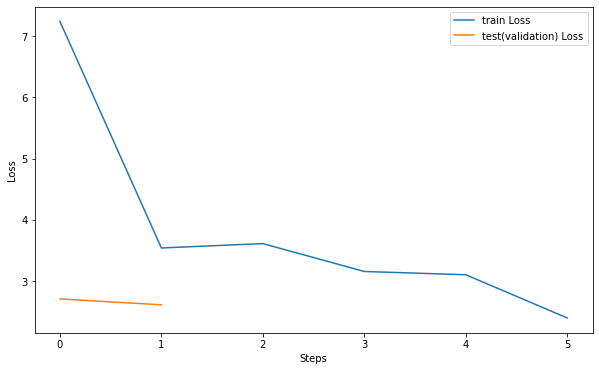

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(losses, label="train Loss")
plt.plot(losses_val, label="test(validation) Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
scores = pd.DataFrame(rouge)
rouge1 = pd.DataFrame(scores['rouge-1'].to_list())
rouge2 = pd.DataFrame(scores['rouge-2'].to_list())
rougeL = pd.DataFrame(scores['rouge-l'].to_list())

scores.keys()

Index(['rouge-1', 'rouge-2', 'rouge-l'], dtype='object')

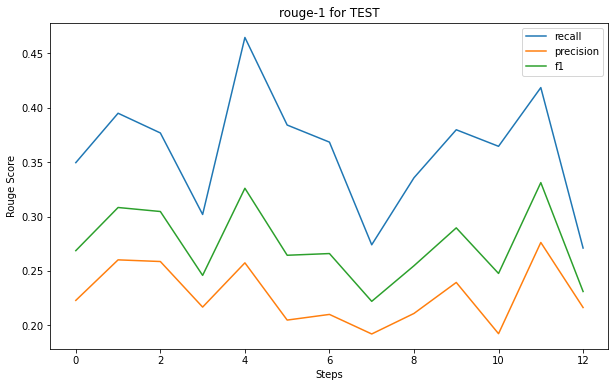

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-1 for TEST')
plt.plot(rouge1['r'].to_list(), label="recall")
plt.plot(rouge1['p'], label="precision")
plt.plot(rouge1['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

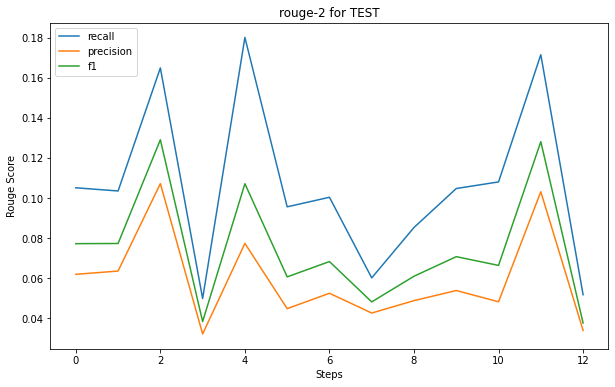

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-2 for TEST')
plt.plot(rouge2['r'].to_list(), label="recall")
plt.plot(rouge2['p'], label="precision")
plt.plot(rouge2['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

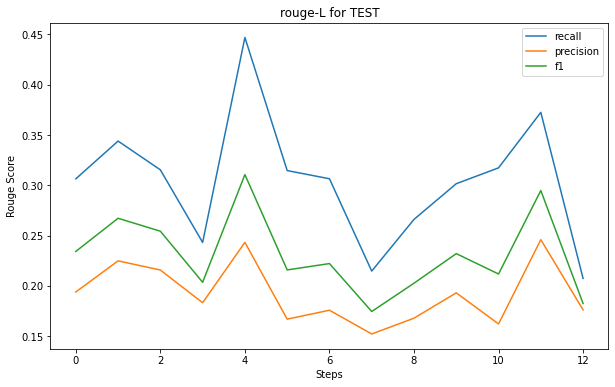

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-L for TEST')
plt.plot(rougeL['r'].to_list(), label="recall")
plt.plot(rougeL['p'], label="precision")
plt.plot(rougeL['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

In [ ]:
scores_t = pd.DataFrame(rouge_train)
rouge1_t = pd.DataFrame(scores_t['rouge-1'].to_list())
rouge2_t = pd.DataFrame(scores_t['rouge-2'].to_list())
rougeL_t = pd.DataFrame(scores_t['rouge-l'].to_list())

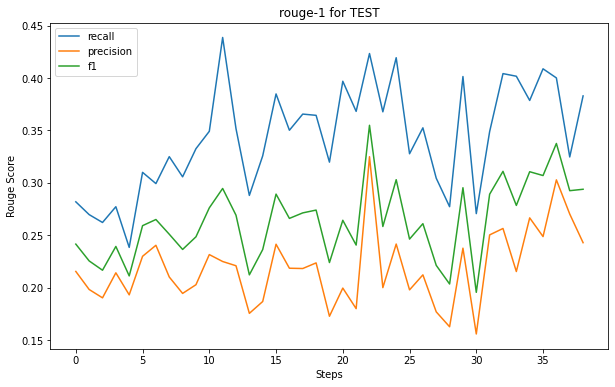

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-1 for Train')
plt.plot(rouge1_t['r'].to_list(), label="recall")
plt.plot(rouge1_t['p'], label="precision")
plt.plot(rouge1_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

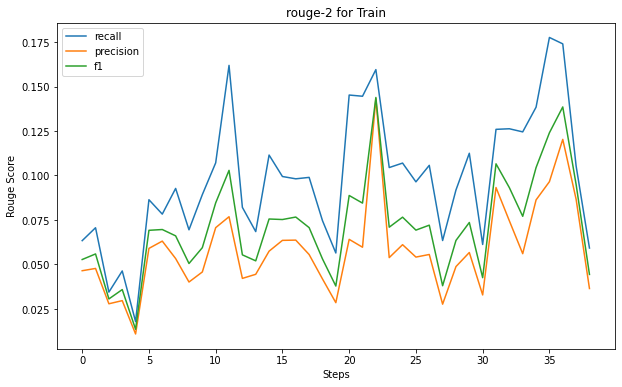

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-2 for Train')
plt.plot(rouge2_t['r'].to_list(), label="recall")
plt.plot(rouge2_t['p'], label="precision")
plt.plot(rouge2_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()

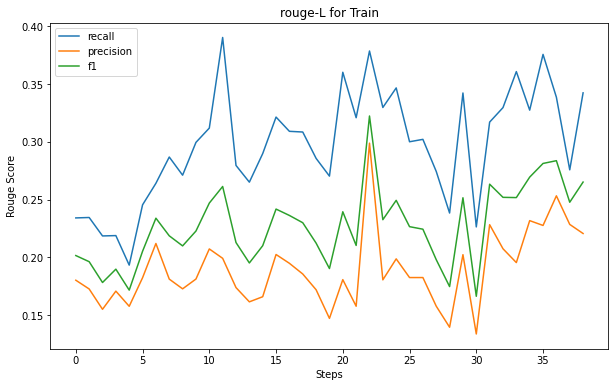

In [ ]:
plt.figure(figsize=(10,6))

plt.title('rouge-L for Train')
plt.plot(rougeL_t['r'].to_list(), label="recall")
plt.plot(rougeL_t['p'], label="precision")
plt.plot(rougeL_t['f'], label="f1")

plt.xlabel("Steps")
plt.ylabel("Rouge Score")
plt.legend()
plt.show()